In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import math as m
from sklearn.metrics import accuracy_score
from cvxopt import matrix, solvers
from numpy import array

import cvxopt

#import cvxopt.solvers
#from cvxopt import matrix as cvxopt_matrix
#from cvxopt import solvers as cvxopt_solvers

%matplotlib inline


In [2]:
train_data = pd.read_csv('train.csv', header=None)
test_data = pd.read_csv('test.csv', header=None)


In [3]:
data_train = train_data.iloc[:6800,1:]
data_train = data_train.to_numpy()

data_val = train_data.iloc[6800:,1:]
data_val = data_val.to_numpy()

label_train = train_data.iloc[:6800,0]
label_train = label_train.to_numpy()

label_val = train_data.iloc[6800:,0]
label_val = label_val.to_numpy()

print(data_train.shape, data_val.shape, label_train.shape, label_val.shape)

(6800, 200) (1700, 200) (6800,) (1700,)


In [4]:
data_test = test_data.iloc[:,1:]
data_test = data_test.to_numpy()

label_test = test_data.iloc[:,0]
label_test = label_test.to_numpy()

In [5]:
#change label 0 to -1
label_train = np.where(label_train==0, -1, label_train) 
label_val = np.where(label_val==0, -1, label_val) 
label_test = np.where(label_test==0, -1, label_test) 


### Dual

In [6]:
def svm_train_dual(X, y, regularisation_para_C):
    m,n = data_train.shape
    
    y = y.reshape(-1,1) * 1.
    
    y_diag = np.asarray(np.diag(np.ones(y.shape[0]))*y) 
    X_dd = np.dot(y_diag, X)
    X_dd.shape
    
    H = np.dot(X_dd , X_dd.T) * 1.
    P = matrix(H)
    q = matrix(-np.ones((m, 1)))
    g1 = np.eye(m)*-1
    g2 = np.eye(m)
    g3 = np.vstack((g1,g2))
    G = matrix(g3)
    
    h1 = np.zeros(m)
    h2 = np.ones(m)
    h = np.hstack((h1, h2 * regularisation_para_C/m))
    h = matrix(h)
    
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    
    w1 = (y * alphas).T @ X
    w = w1.reshape(-1,1)

    S = (alphas > 1e-4).flatten()
    b = y[S] - np.dot(X[S], w)
    b = b.mean()
    svm_model_d = np.vstack((w,b))
    return svm_model_d

In [7]:
def svm_predict_dual(data_test, label_test, svm_model_d):    
    m,n = data_train.shape
    y_pred = np.dot(svm_model_d[:n].T, data_test.T)+svm_model_d[-1]
    y_pred = np.sign(y_pred)
    y_pred = y_pred.reshape(label_test.shape)
    score = accuracy_score(label_test, y_pred)
    return score

In [8]:
C_param = [1, 5, 10, 15, 20, 50, 75, 100]

for i in C_param:
    svm_model_d = svm_train_dual(data_train , label_train , i)
    test_accuracy_d = svm_predict_dual(data_val , label_val , svm_model_d)
    print(i, test_accuracy_d)

     pcost       dcost       gap    pres   dres
 0: -6.6642e+02 -2.3866e+00  7e+04  3e+02  6e-13
 1: -6.8933e+00 -2.3864e+00  7e+02  3e+00  6e-13
 2: -2.9663e-01 -2.3650e+00  1e+01  4e-02  1e-14
 3: -1.7203e-01 -1.6592e+00  2e+00  4e-03  2e-15
 4: -1.6674e-01 -3.7098e-01  2e-01  2e-04  4e-15
 5: -2.1463e-01 -2.7816e-01  7e-02  4e-05  2e-15
 6: -2.2943e-01 -2.5920e-01  3e-02  2e-05  2e-15
 7: -2.3590e-01 -2.5074e-01  2e-02  7e-06  2e-15
 8: -2.3976e-01 -2.4571e-01  6e-03  2e-06  2e-15
 9: -2.4152e-01 -2.4347e-01  2e-03  6e-07  2e-15
10: -2.4216e-01 -2.4268e-01  5e-04  9e-08  2e-15
11: -2.4239e-01 -2.4243e-01  4e-05  3e-09  2e-15
12: -2.4241e-01 -2.4241e-01  1e-06  8e-11  2e-15
13: -2.4241e-01 -2.4241e-01  2e-08  1e-12  2e-15
Optimal solution found.
1 0.9752941176470589
     pcost       dcost       gap    pres   dres
 0: -6.6682e+02 -1.1742e+01  7e+04  3e+02  6e-13
 1: -7.6408e+00 -1.1736e+01  7e+02  3e+00  6e-13
 2: -1.0220e+00 -1.1176e+01  4e+01  1e-01  3e-14
 3: -5.8089e-01 -6.0065e+0

In [9]:
#predict with best performing hyperparameter C 10

svm_model_d = svm_train_dual(data_train , label_train , 10)

test_accuracy_d_train = svm_predict_dual(data_train , label_train , svm_model_d)
print('train accuracy is', test_accuracy_d_train)

test_accuracy_d_val = svm_predict_dual(data_val , label_val , svm_model_d)
print('validation accuracy is', test_accuracy_d_val)

test_accuracy_d_test = svm_predict_dual(data_test , label_test , svm_model_d)
print('test accuracy is', test_accuracy_d_test)

     pcost       dcost       gap    pres   dres
 0: -6.6731e+02 -2.3438e+01  7e+04  3e+02  7e-13
 1: -8.5954e+00 -2.3413e+01  7e+02  3e+00  6e-13
 2: -1.9031e+00 -2.1365e+01  7e+01  2e-01  4e-14
 3: -1.0988e+00 -1.0456e+01  1e+01  2e-02  7e-15
 4: -7.8342e-01 -2.4697e+00  2e+00  3e-03  1e-14
 5: -9.3191e-01 -1.5689e+00  7e-01  9e-04  6e-15
 6: -9.7760e-01 -1.4105e+00  5e-01  5e-04  4e-15
 7: -1.0229e+00 -1.2698e+00  3e-01  2e-04  3e-15
 8: -1.0518e+00 -1.1920e+00  1e-01  1e-04  2e-15
 9: -1.0765e+00 -1.1407e+00  7e-02  3e-05  3e-15
10: -1.0915e+00 -1.1134e+00  2e-02  6e-06  3e-15
11: -1.0982e+00 -1.1037e+00  6e-03  1e-06  4e-15
12: -1.1001e+00 -1.1012e+00  1e-03  1e-07  4e-15
13: -1.1005e+00 -1.1007e+00  2e-04  1e-08  4e-15
14: -1.1006e+00 -1.1006e+00  6e-06  5e-10  5e-15
15: -1.1006e+00 -1.1006e+00  2e-07  1e-11  5e-15
Optimal solution found.
train accuracy is 0.9760294117647059
validation accuracy is 0.9770588235294118
test accuracy is 0.972


In [10]:
#getting weights and bias for dual model
w = svm_model_d[:data_train.shape[1]]
b = svm_model_d[-1]
dual_w_series = pd.Series(w.flatten())
dual_b_series = pd.Series(b)
dual_series = pd.concat((dual_w_series, dual_b_series), axis=0)

### Primal

In [11]:
#Primal soft margin

def svm_train_primal(X,y,regularisation_para_C):
    m,n = X.shape
    Pw = np.asarray(np.diag(np.ones(n))) 
    Ps = np.zeros([n, m]) 
    Pb = np.zeros([1, n]) 
    
    P1 = np.zeros([m, m])
    P2 = np.zeros([m, 1])
    P3 = np.zeros([1, m])
    P4 = np.zeros([1, 1]) 
    
    Pup = np.concatenate((Pw, Ps, Pb.T),axis = 1) 
    Pmid = np.concatenate((Ps.T, P1, P2), axis=1)
    Pdown = np.concatenate((Pb,P3, P4),axis = 1)
    P = cvxopt.matrix(np.concatenate((Pup, Pmid, Pdown), axis = 0))
    
    q = np.concatenate((Pb, np.matrix(np.ones([m])*regularisation_para_C/m), P4), axis=1)
    q = cvxopt.matrix((q.T))
    
    g1 = np.dot(np.diag(y),X)*-1
    g2 = np.asarray(np.diag(np.ones([m])*-1))
    g3 = np.matrix(y)*-1
    g3 = g3.T
    g4 = np.zeros([m, n+1])
    g5 = np.asarray(np.diag(np.ones([m])*-1))

    G1 = np.concatenate((g1,g2,g3), axis = 1)
    G2 = np.concatenate((g4,g5), axis = 1)

    G = np.vstack((G1,G2))
    G = cvxopt.matrix(G) 
    
    h1 = np.ones(m)*-1
    h2 = np.zeros(m)
    h = cvxopt.matrix(np.hstack((h1,h2)))             

    svm_model = np.array(cvxopt.solvers.coneqp(P,q,G,h)['x']).flatten()
    
    return svm_model


def svm_predict_primal(data_test, label_test, svm_model):
    m,n = data_train.shape
    w_prim = svm_model[:n]
    b_prim = svm_model[-1]
    
    y_pred = np.dot(data_test, w_prim)+b_prim
    y_pred = np.sign(y_pred)
    
    score = accuracy_score(label_test, y_pred)
    return score

In [12]:
C_param = [1, 5, 10, 15, 20, 50, 75, 100]

for i in C_param:
    svm_model = svm_train_primal(data_train , label_train , i)
    test_accuracy = svm_predict_primal(data_val , label_val, svm_model)
    print(i, test_accuracy)

     pcost       dcost       gap    pres   dres
 0:  1.4602e-01  6.6738e+02  7e+04  3e+00  4e+04
 1:  2.3620e+00 -7.1394e+02  7e+02  3e-02  5e+02
 2:  2.3653e+00 -1.3468e+01  2e+01  6e-04  9e+00
 3:  1.8273e+00 -1.4054e+00  3e+00  9e-05  1e+00
 4:  5.5964e-01  1.4574e-01  4e-01  3e-15  2e-15
 5:  3.0464e-01  2.0083e-01  1e-01  2e-15  1e-15
 6:  2.7023e-01  2.2348e-01  5e-02  1e-15  1e-15
 7:  2.5392e-01  2.3426e-01  2e-02  1e-15  1e-15
 8:  2.4647e-01  2.3940e-01  7e-03  1e-15  7e-16
 9:  2.4351e-01  2.4153e-01  2e-03  1e-15  4e-15
10:  2.4269e-01  2.4216e-01  5e-04  1e-15  2e-15
11:  2.4243e-01  2.4239e-01  4e-05  1e-15  3e-15
12:  2.4241e-01  2.4241e-01  1e-06  1e-15  8e-15
13:  2.4241e-01  2.4241e-01  3e-08  1e-15  3e-14
Optimal solution found.
1 0.9741176470588235
     pcost       dcost       gap    pres   dres
 0:  5.3527e-01  6.7673e+02  7e+04  3e+00  4e+04
 1:  1.1612e+01 -7.2266e+02  7e+02  3e-02  5e+02
 2:  1.1199e+01 -3.6226e+01  5e+01  2e-03  3e+01
 3:  6.9696e+00 -2.8811e+0

In [13]:
svm_model = svm_train_primal(data_train , label_train , 10)

test_accuracy_train = svm_predict_primal(data_train , label_train , svm_model)
print('test_accuracy_train', test_accuracy_train)

test_accuracy_val = svm_predict_primal(data_val , label_val , svm_model)
print('test_accuracy_val', test_accuracy_val)

test_accuracy_test = svm_predict_primal(data_test , label_test , svm_model)
print('test_accuracy_test', test_accuracy_test)


     pcost       dcost       gap    pres   dres
 0:  1.0159e+00  6.8843e+02  7e+04  3e+00  4e+04
 1:  2.3159e+01 -7.4260e+02  8e+02  4e-02  5e+02
 2:  2.1449e+01 -5.9102e+01  8e+01  3e-03  4e+01
 3:  1.2255e+01 -4.8566e+00  2e+01  4e-04  5e+00
 4:  2.8854e+00  2.7904e-01  3e+00  4e-05  5e-01
 5:  1.6190e+00  8.2015e-01  8e-01  1e-05  1e-01
 6:  1.4284e+00  9.2156e-01  5e-01  5e-06  8e-02
 7:  1.2900e+00  9.9213e-01  3e-01  2e-06  3e-02
 8:  1.2058e+00  1.0372e+00  2e-01  1e-06  2e-02
 9:  1.1498e+00  1.0686e+00  8e-02  4e-07  6e-03
10:  1.1165e+00  1.0889e+00  3e-02  7e-08  1e-03
11:  1.1043e+00  1.0977e+00  7e-03  1e-08  2e-04
12:  1.1013e+00  1.1000e+00  1e-03  2e-09  2e-05
13:  1.1007e+00  1.1005e+00  2e-04  2e-10  3e-06
14:  1.1006e+00  1.1006e+00  9e-06  9e-12  1e-07
15:  1.1006e+00  1.1006e+00  2e-07  2e-13  3e-09
Optimal solution found.
test_accuracy_train 0.9769117647058824
test_accuracy_val 0.9770588235294118
test_accuracy_test 0.9706666666666667


In [14]:
w_prim = svm_model[:data_train.shape[1]]
b_prim = svm_model[-1]
primal_weights = pd.Series(w_prim)
primal_b = pd.Series(b_prim)
primal_series = pd.concat([primal_weights, primal_b], axis=0) 

### SVM Library

In [15]:
from sklearn.svm import SVC

C_param = [1, 3, 5, 7, 10, 15, 20, 50, 75, 100]
C_param = [element / data_train.shape[0] for element in C_param]

for i in C_param:
    clf = SVC(C = i, kernel = 'linear')
    clf.fit(data_train, label_train) 
    y_ = clf.predict(data_val)
    score = accuracy_score(label_val, y_)
    print(i*data_train.shape[0], score)

0.9999999999999999 0.9741176470588235
3.0 0.9764705882352941
5.0 0.9758823529411764
7.000000000000001 0.9758823529411764
10.0 0.9770588235294118
15.0 0.9752941176470589
20.0 0.9752941176470589
50.0 0.9729411764705882
75.0 0.9735294117647059
100.0 0.9741176470588235


In [16]:
clf = SVC(C = 10/data_train.shape[0], kernel = 'linear')
clf.fit(data_train, label_train) 

y_pred_train = clf.predict(data_train)
train_score = accuracy_score(label_train, y_pred_train)
print('train score',train_score)


y_pred = clf.predict(data_test)
test_score = accuracy_score(label_test, y_pred)
print('test score',test_score)

train score 0.9769117647058824
test score 0.9706666666666667


In [17]:
SVM_w = clf.coef_
SVM_b = clf.intercept_
SVM_w_series = SVM_w.flatten()
SVM_w_series = pd.Series(SVM_w_series)
SVM_b_series = pd.Series(SVM_b)
SVM_series = pd.concat((SVM_w_series, SVM_b_series), axis=0)

In [18]:
#weight and bias compare
param_compare = pd.concat([dual_series.rename('dual'), primal_series.rename('primal')], axis=1)
param_dif = round((param_compare['primal'] - param_compare['dual']),4)
param_diff = (param_compare['primal'] - param_compare['dual'])/param_compare['dual']*100
param_compare_1 = pd.concat([param_compare, param_dif.rename('D_P_dif'), param_diff.rename('D_P_diff pct')], axis=1)
param_compare_1

,dual,primal,D_P_dif,D_P_diff pct
0,0.003583,0.003583,-0.0000,-0.002751
1,-0.023844,-0.023844,-0.0000,0.000417
2,0.030614,0.030614,-0.0000,-0.000508
3,-0.008669,-0.008669,0.0000,-0.002876
4,0.028168,0.028167,-0.0000,-0.001835
...,...,...,...,...
196,-0.021071,-0.021070,0.0000,-0.003592
197,0.000170,0.000171,0.0000,0.466676
198,-0.007237,-0.007236,0.0000,-0.011780
199,-0.000761,-0.000761,-0.0000,0.016109


In [19]:
#only weights compare
weights_compare_2 = param_compare_1.iloc[:200]
weights_compare_2.describe()

,dual,primal,D_P_dif,D_P_diff pct
count,200.000000,200.000000,200.0,200.000000
mean,-0.000931,-0.000930,0.0,0.002686
std,0.054769,0.054769,0.0,0.046644
min,-0.370321,-0.370321,-0.0,-0.186741
25%,-0.010879,-0.010879,0.0,-0.002131
50%,-0.000824,-0.000824,0.0,-0.000562
75%,0.010700,0.010700,-0.0,0.001640
max,0.421672,0.421672,-0.0,0.466676


In [20]:
param_compare_1.describe()

,dual,primal,D_P_dif,D_P_diff pct
count,201.000000,201.000000,201.000000,201.000000
mean,0.004475,0.004760,0.000285,0.028904
std,0.094115,0.097430,0.004035,0.374599
min,-0.370321,-0.370321,-0.000000,-0.186741
25%,-0.010844,-0.010843,0.000000,-0.002120
50%,-0.000761,-0.000761,-0.000000,-0.000527
75%,0.011016,0.011016,0.000000,0.001666
max,1.085559,1.142794,0.057200,5.272415


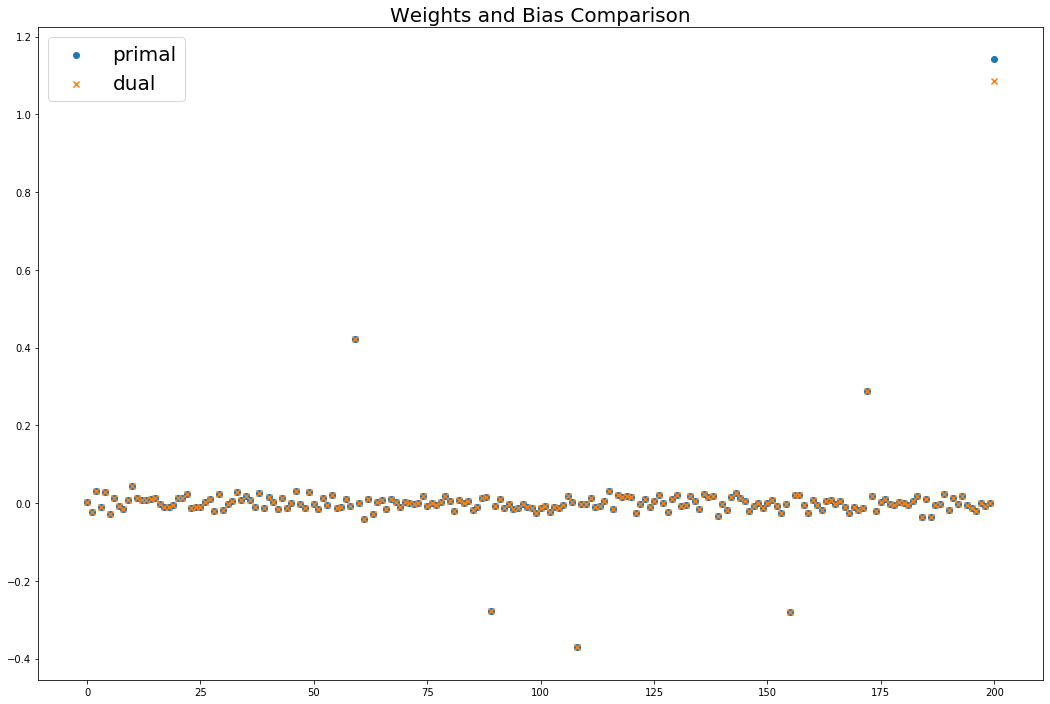

In [21]:
#plotting w and b

plt.figure(figsize=(18,12))
x = range(0,201)
plt.scatter(x, param_compare_1['primal'], alpha=1, label="primal")
plt.scatter(x, param_compare_1['dual'], alpha=1, marker = 'x', label="dual" )
plt.title('Weights and Bias Comparison', fontsize=20)
plt.legend(loc='upper left', prop={'size': 20})